In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sympy import *
import matplotlib.pyplot as plt
init_printing(use_latex=true)
filename = "TestData.xlsx"

In [2]:
# Establish symbols
n, T, i, t, lda, eps = symbols('n T i t \lambda \epsilon')       # n wells & T timepoints

In [3]:
# Establish number of wells
n = pd.read_excel(filename, sheet_name='n').iloc[0,0]
n

5

In [4]:
# Establish number of timepoints
T = pd.read_excel(filename, sheet_name='T').iloc[0,0]
T

41

In [5]:
# Establish binary matrix for wells being on or off
z = MatrixSymbol('z', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(z.as_explicit())
zReal = Matrix(pd.read_excel(filename, sheet_name="OnOff").to_numpy().T)
zReal

⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1 
⎢                                                                             
⎣0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1⎤
                                            ⎥
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1⎥
                                            ⎥
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1⎥
                                            ⎥
 1  1  1  1 

In [6]:
# Establish binary matrix for wells being measured or not
d = MatrixSymbol('d', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(d.as_explicit())
dReal = Matrix(pd.read_excel(filename, sheet_name="Measured").to_numpy().T)
dReal

⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎣0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0⎤
                                            ⎥
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0⎥
                                            ⎥
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0⎥
                                            ⎥
 0  0  0  0 

In [7]:
# Establish matrix of actual mass flows
m = MatrixSymbol('m', n, T)  
#pprint(m.as_explicit())
mReal = Matrix(pd.read_excel(filename, sheet_name="MassFlows").to_numpy().T)
mReal

⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  70.3  143.1  140.6  138
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  65.5  133.1  130.6  128
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0      0    36.0   61.
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0      0      0      0
⎢                                                                             
⎣0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   0      0      0      0

.4  136.4  134.7  133.5  132.7  132.0  130.8  127.3  123.8  122.4  121.5  120.
                                                                              
.4  126.4  124.7  123.5  122.7  122.0  120.8  117.3  113.8  112.4  111.5  110.
                                                   

In [8]:
# Establish matrix / vector of total mass flow
M = MatrixSymbol('M', 1, T)
#pprint(M.as_explicit())
MReal = Matrix(pd.read_excel(filename, sheet_name="TotalMassFlow").to_numpy().T)
MReal

[0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0.02  135.81  276.19  307.
2  328.59  327.84  359.56  365.59  363.27  361.32  358.23  385.31  482.47  481
.56  478.19  475.64  473.44  471.56  469.85  468.27  466.42  464.29  461.96  4
60.39]

In [9]:
# Establish solution vectors of initial mass flows and gradients per well 
wg = MatrixSymbol('wg', n, 1)
pprint(wg.as_explicit())
wc = MatrixSymbol('wc', n, 1)
pprint(wc.as_explicit())

# At any timepoint, w = wc + t*wg

⎡wg₀₀⎤
⎢    ⎥
⎢wg₁₀⎥
⎢    ⎥
⎢wg₂₀⎥
⎢    ⎥
⎢wg₃₀⎥
⎢    ⎥
⎣wg₄₀⎦
⎡wc₀₀⎤
⎢    ⎥
⎢wc₁₀⎥
⎢    ⎥
⎢wc₂₀⎥
⎢    ⎥
⎢wc₃₀⎥
⎢    ⎥
⎣wc₄₀⎦


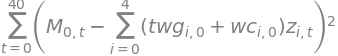

In [10]:
S1 = Sum((M[0,t] - Sum(z[i, t]*(wc[i,0]+t*wg[i,0]), (i, 0, n-1)))**2 , (t, 0, T-1))
S1

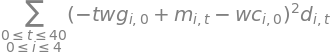

In [11]:
S2 = Sum(Sum(d[i,t]*((m[i,t]-(wc[i,0]+t*wg[i,0])))**2 , (t, 0, T-1)), (i, 0, n-1))
S2

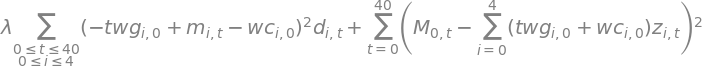

In [12]:
I = S1 + lda*S2
I

In [13]:
Inaccuracy = I.subs({M: MReal, z: zReal, d: dReal, m: mReal})
Inaccuracy

                                                                              
                                                                              
                                                                              
                                                                              
           4       40                                                         
        _______ _______                                                       
        ╲       ╲                                                             
         ╲       ╲                                                            
          ╲       ╲     ⎛                ⎛⎡0  0  0  0  0  0  0  0  0  0  0  0 
           ╲       ╲    ⎜                ⎜⎢                                   
            ╲       ╲   ⎜                ⎜⎢0  0  0  0  0  0  0  0  0  0  0  0 
             ╲       ╲  ⎜                ⎜⎢                                   
\lambda⋅     ╱       ╱  ⎜-t⋅(wg)[i, 0] + ⎜⎢0  0  0  

In [41]:
# Testing with test result
wEval = Matrix([130, 120, 60, 50, 140, -1, -2, -2, -2, -3])
regHP = 1
#wEval[n:2*n,0]
Inaccuracy.subs({wc: wEval[0:n,0], wg: wEval[n:2*n,0], lda: regHP}).doit()

In [14]:
def inac(wTest, *args):
    # Unpack arguments
    regHP = args[0]
    Inaccuracy = args[1]
    n = args[2]
    wEval = Matrix(wTest)
    # Solve and return the inaccuracy of the wTest solution
    val = Inaccuracy.subs({wc: wEval[0:n,0], wg: wEval[n:2*n,0], lda: regHP}).doit()
    return(val)

In [15]:
# Minimise using scipy to find minima
w0 = [130, 110, 55, 45, 140, -1, -2, -2, -2, -3]
regHP = 1
args = (regHP, Inaccuracy, n)
wFound = minimize(inac, w0, args=args, method='Nelder-Mead', tol=10)

In [19]:
# Gives a result after 87 iterations and 150 functions evaluations:
#wTolpoint1  = [ 1.237e+02,  1.081e+02,  7.231e+01,  4.457e+01,  1.193e+02]
ans = wFound.x
ans

array([144.78679749, 133.50233478, 109.24677077,  40.47164349,
       177.31408299,  -1.48354737,  -1.30569256,  -0.88240173,
         0.68232122,  -1.11939694])

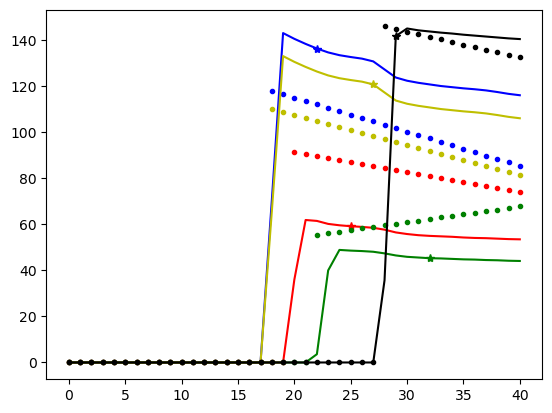

In [28]:
# Plot results from well 1
colours=['b', 'y', 'r', 'g', 'k']
for i in range(n):
    plt.plot(range(T),mReal[i,:][:], colours[i]+'-')
    # Plot Time-Dependently
    for t in range(T):
        ansplot = (ans[i]+t*ans[i+n])
        plt.plot(t,ansplot*zReal[i,t], colours[i]+'.')
    for month,element in enumerate(dReal[i,:]):
        if element==1:
            plt.plot(month, mReal[i,month], colours[i]+'*')



Use .diff() to get derivatives and solve for stationary points, second derivatives for minima. - Differentiate Inac with resepect to each w - solve 2n equations simultaneously (invertible matrix?)

Design matrix of linear regression - EngSci 205

Bayesian vs grid search approach for regularisation parameter tuning (MH?) - Need to make solving more efficient for this to be feasible

Replace flat w with linearly time-dependent w - Currently too slow to solve this 

Sympy function - Python - use Bayesian approach to estimate cost function
Optuner or other - bayesian optimisation package